Second Version of [2021_2022_RNN_Robust_All_Models](2021_2022_RNN_Robust_All_Models.ipynb)

here V_rise Threshold=1.0225

Combined predictions of 3 models to evaluate wether a voltage rise will occur in next step
- **Model1** : Compute power flow and get voltage rise based on Predicted $\tilde{X(k)}$ and $\tilde{Y(k)}$ 
- **Model2** : Predict binary voltage rise i.e. 0 or 1
- **Model3** : Predic the value of the voltage rise based on inputs 


---

#### Import modules to be used

In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # Profiling   
import seaborn as sbn
import pickle, sys, importlib,  time
import os
from pickle import load
import tensorflow as tf
import joblib
import ipyparallel as ipp


#### Import Module for ML

#### Import my own modules

In [2]:
# import psutil
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: parsys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [3]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

# To use later in functions 
sum_max_main_network = (sum_max_p_mw_StLaurent_prodBT, sum_max_p_mw_StLaurent_load)


#### Import Network data

In [4]:
#Load files
file_p_inj_0013 = 'Prod_HTA/PROD_Bis/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/PROD_Bis/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'


# The  commissioning of the Prod P0100 is recent (2022). I therefore use the data of the closer energy 
# producer that is P0058  and consider it as that of Prod P0100 
file_p_inj_0100 = 'Prod_HTA/PROD_Bis/PROD-SERGIES 2204 (LA ROCHE A CORNUCHON)-PINDRAY - Actif P-.csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'


# Get files data 
p_mw_0013 = oriFc.readAndReshape_excelFile(file_p_inj_0013 ,excel_folder, )
p_mw_0018 = oriFc.readAndReshape_excelFile(file_p_inj_0018 ,excel_folder,)
p_mw_0100 = oriFc.readAndReshape_excelFile(file_p_inj_0100 ,excel_folder,)


p_mw_prod_bt_total = oriFc.readAndReshape_excelFile(file_prod_bt_total, excel_folder)
p_mw_cons_total = oriFc.readAndReshape_excelFile(file_cons_total, excel_folder)

# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013[:len(p_mw_0100)], 
                'P0018': p_mw_0018[:len(p_mw_0100)],
                'P0100': p_mw_0100[:len(p_mw_0100)]
               }
# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0100), freq='10T')

# Use the create dict to create a dataFrame for Prod P0100
df_prodP0100 = pd.DataFrame(p_mw_0100, index=per_index)

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_prod_bt_total), freq='10T')
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])


# Dataframe Conso BT 
per_index = pd.period_range('01 01 2020', periods=len(p_mw_cons_total), freq='10T')
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=['Cons'])
# Data cleaning on Consumption
previous_days = df_cons_total[(per_index>='2022 02 12') & (per_index<='2022 02 21 23:50')]
following_days = df_cons_total[(per_index>='2022 03 03') & (per_index<='2022 03 12 23:50')]
# # Put the interpolated data into the dataframe
df_cons_total[(per_index>='2022 02 21') & (per_index<='2022 03 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2


# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# # Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

# Select relevant data up to 2022 06 01
df_prodHT = df_prodHT[df_prodHT.index<='2022 06 01 23:50']
df_prod_bt_total = df_prod_bt_total[df_prod_bt_total.index<='2022 06 01 23:50']
df_cons_total = df_cons_total[df_cons_total.index<='2022 06 01 23:50']


# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
h_start_end = ('07:00','18:50') # for the persistance model, the previous period i.e. 06:50 
                                # is needed to compute the first instant i.e. 07:00
per_index = df_prodHT.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*h_start_end) ).index.to_period('10T')
day_tot_per = len(per_daylight[(per_daylight.year==2020)&(per_daylight.month==1)&(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT], axis=1).loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[df_data.index>='2021 06 01']
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time('07:00','18:50') ).index.to_period('10T')


#### Import Simulation results from [Model2](voltageRiseBin_Sim.ipynb) and [Model3](VoltageRiseNum_Pred)

In [ ]:
pred_num_vRise = joblib.load('pickle_files/simulationResults/Numerical_Voltage_Rise_Predicted.pkl')
pred_bin_vRise = joblib.load('pickle_files/simulationResults/Binary_Voltage_Rise_Predicted2.pkl')

#### Create a mask for the period to work with 

In [8]:
mask_per2work = pred_bin_vRise[pred_bin_vRise.index>='2021 06 02'].index # We select from the second day of testing set 
# since Model1  needs a whole day to predict the first period

# Select the period of 09Am to 07Pm for all days considered
mask_per2work = mask_per2work.to_timestamp().to_series().between_time('08:10','18:30').index.to_period('10T')


#### Load prediction file of model1 
i.e. $\tilde{X(k)}$ an  $\tilde{Y(k)}$ predicted in [RNN_Sim_StLaurentDeJourdes](RNN_Sim_StLaurentDeJourdes.ipynb)

In [9]:
pred_Model1_df = joblib.load('pickle_files/simulationResults/RNN_pred.pkl')

#### Start Parallel engines

In [10]:
n_engines = 7  # Total number of engines
# (Use the real maximum cpu and not the logical)            
cluster = ipp.Cluster(n=n_engines) # Create cluster
cluster.start_cluster_sync()       # Start cluster 
rc = cluster.connect_client_sync() # connect client
rc.wait_for_engines(n_engines)     # Wait for engines to be available for all clients
dview = rc[:]                      # Create a direct view of all engine or clients that would
                                   # be used to command each client

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

## OPF  RNN

#### Load network

In [11]:
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 

# Add a controllable line to the static generators
net_civaux.sgen['controllable'] = False 

# Set the producer P0100 as a controllable load
net_civaux.sgen['controllable'][net_civaux.sgen.name=='P0100'] = True

# Add Missing columns to be able to un an opf 
net_civaux.sgen[['min_p_mw', 'min_q_mvar', 'max_q_mvar']]=0.

# Rename data in bus network because the names do not correspond to the parameters in pandapower 
net_civaux.bus.rename({'max_vw_pu':'max_vm_pu',}, axis=1, inplace=True)

net_civaux.bus.drop(['max_vm', 'min_vm'], axis=1, inplace=True)    # Delete useless parameters
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1]   # Extract HV bus in the network

pp.runpp(net_civaux) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index2 = list(net_civaux.res_bus.vm_pu[net_civaux.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux_hv_activated_bus = [i for i in activated_bus_index2 
                               if i in net_civaux_hv_bus.index]

#### Add maximum voltage constraints on the Buses in the network 

In [12]:
vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choosen 
# vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choosen 

# net_civaux.bus.max_vm_pu[net_civaux.bus.max_vm_pu.notna()] = vm_mu_max
net_civaux.bus.max_vm_pu[net_civaux_hv_activated_bus] = vm_mu_max
net_civaux.bus.min_vm_pu[net_civaux_hv_activated_bus] = vm_mu_min


#### Controllable Generators costs

In [13]:
# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
cost_sgen_p0100 = pp.create_poly_cost(net_civaux,23,'sgen', cp1_eur_per_mw=-1)
# net_civaux.poly_cost.cp1_eur_per_mw.at[cost_sgen_p0100]=-0.5
net_civaux.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Define Data to use in local space of parallel engines

##### Create a function to rename Columns name 


    Ex: from ==> ['P0013_RNN', 'P0018_RNN', 'P0100_RNN'] ==> to ['P0013', 'P0018', 'P0100']

In [14]:
rename = lambda name_list : [name.split('_R')[0] for name in name_list]

##### Extract predicted values  from Model1 and rename it

In [18]:
df_prodHT = pred_Model1_df[['P0013_RNN','P0018_RNN','P0100_RNN']] 
df_prod_bt_total = pred_Model1_df[['Prod_BT_RNN']]
df_cons_total = pred_Model1_df[['Cons_RNN']]

df_prodHT.columns, df_prod_bt_total.columns, df_cons_total.columns = map(rename, 
                                                                         [df_prodHT.columns, 
                                                                          df_prod_bt_total.columns, 
                                                                          df_cons_total.columns ])

##### Create dictionnary of predicted values

In [19]:
# Define a dict 
dict_df_sgenLoad = dict({'df_prodHT':df_prodHT, 
                         'df_prod_bt_total':df_prod_bt_total, 
                         'df_cons_total':df_cons_total } )

#### Send data into local space of each engine

In [20]:
# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_oriFunctions, tqdm, importlib
    importlib.reload(par_oriFunctions)
    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', df_prodHT.index)

# Parameters for the persistence model
opf_status = 'Both' 

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status, 
                         })

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run Optimal /power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [21]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

##### Extract results

In [19]:
# Gather the result of each engine in a single list
results = dview.gather('resulting')
time.sleep(1)

# Extract results
model1_pred_res = oriFc.extract_par_results(results, df_prodHT)

# Get maximum volatage over the network 
max_vm_pu_df_RNN = model1_pred_res[['max_vm_pu_pf']]

#### Combined result of 3 models 
**<span style='color:red'> -----------------  BLOC  robust Pred -------------------  </span>**

In [83]:
# Apply period to work with to all three model output
model1_Vrise, model2_Vrise, model3_Vrise = (max_vm_pu_df_RNN.loc[mask_per2work], 
                                            pred_num_vRise.loc[mask_per2work], 
                                            pred_bin_vRise.loc[mask_per2work] )

# create a dictionnary to save modelVrise
v_rise_dict = {name: model for name, model in zip( ['Model'+str(i) for i in range(1,4)], 
                                                  [model1_Vrise, model2_Vrise, model3_Vrise] ) }

model_name = 'Model3'

# Extract P0100 based on robust prediction of threshold
P0100_opt, all_me = oriFc.robustPred(v_rise_dict, df_final[['P0100']], model1_pred_res[['P0100']],vm_mu_max,3)

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [84]:
P0100_opt.loc[mask_per2work,['P0100']] = np.minimum(df_final.loc[mask_per2work, 'P0100'], P0100_opt.P0100)

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dict to use for power flow


In [85]:
prod_hv_df = pd.concat([df_final.loc[mask_per2work, ['P0013', 'P0018']],P0100_opt], axis=1)

dict_df_sgenLoad = dict({'df_prodHT': prod_hv_df, 
                         'df_prod_bt_total':df_final.loc[mask_per2work, ['Prod_BT']], 
                         'df_cons_total':df_final.loc[mask_per2work, ['Cons']] } )

#### Send data into local space of each engine

In [86]:
# Clear the localspace of all engines
dview.clear() 

# # Import following modules on the local space of clients or engines
with rc[:].sync_imports():
    import numpy, pandapower,pandas, par_oriFunctions, tqdm, importlib
    importlib.reload(par_oriFunctions)
    
# Share the total number of period in df_prodHT.index among all the created engines
dview.scatter('period_part', prod_hv_df.index)

# Parameters for the persistence model
opf_status = False 

# Create a dictionnary containing all the varible that will be used by each client or engine
parameters_dict = dict({'net_civaux':net_civaux, 
                        'net_civaux_hv_activated_bus':net_civaux_hv_activated_bus, 
                        'sum_max_main_network':sum_max_main_network, 
                        'dict_df_sgenLoad':dict_df_sgenLoad,
                        'vm_mu_max':vm_mu_max,
                        'opf_status':opf_status})

dview.push(parameters_dict) # Add all  variables in the parameters_dict 
                            # to  the local space of each client

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing Par_myFunctions on engine(s)
importing tqdm on engine(s)
importing importlib on engine(s)


<AsyncResult(_push): pending>

#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [87]:
%%px 
resulting = [par_oriFunctions.run_powerflow_at(net_civaux, cur_period, net_civaux_hv_activated_bus, 
                                              sum_max_main_network,  dict_df_sgenLoad, vm_mu_max, 
                                              opf_status) for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

#### Extract results

In [88]:
# Gather the result of each engine in a single list
results_pf_rnn = dview.gather('resulting')
time.sleep(1)

# Put data in dataframe
max_vm_pu_rnn_df = pd.DataFrame(data=np.array(results_pf_rnn), 
                                index=prod_hv_df.index, columns=[model_name],)

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Plot created Dataframe

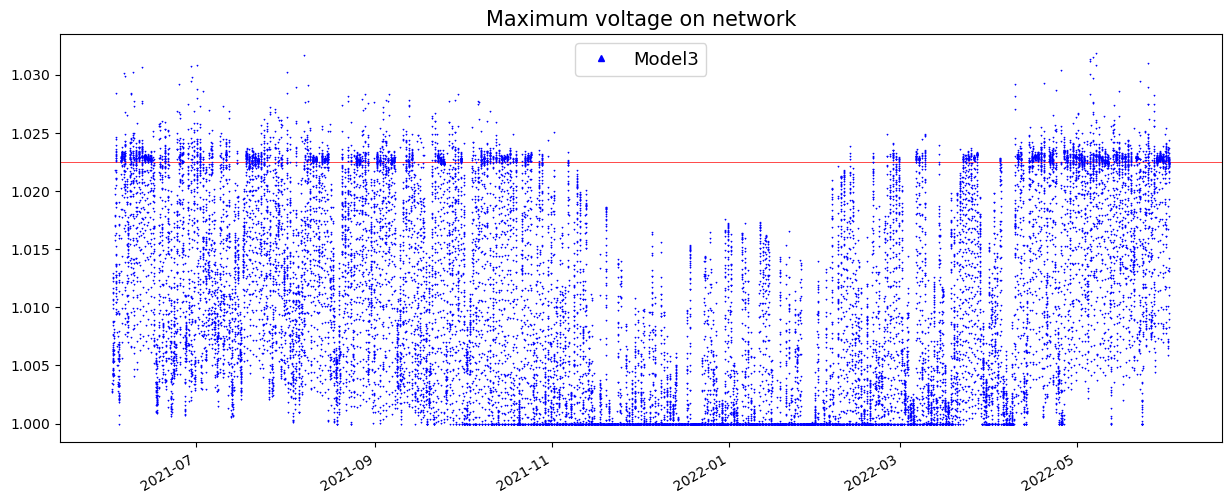

In [89]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

max_vm_pu_rnn_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

In [90]:
P0100_rnn_df = df_final.loc[:,['P0100']]
P0100_rnn_df.columns=['RNN_>=3 Model']
P0100_rnn_df.loc[mask_per2work, 'RNN_>=3 Model'] = P0100_opt.P0100


# Concat
P0100_concat_df = pd.concat([df_final.loc[:,['P0100']],
                             P0100_rnn_df], axis=1)

# # Rename
P0100_concat_df.rename(columns=({'P0100':'No_Control'}), inplace=True);

In [91]:
# Compute Energy
var_no_control, var_rnn = P0100_concat_df.sum()*Δt

print(f'P0100 prod,   No Control  : {var_no_control:.2f} MWh')
print(f'P0100 prod, >=3 Model  : {var_rnn:.2f} MWh |  Perc = {var_rnn*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, >=3 Model  : 4664.28 MWh |  Perc = 89.19%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [92]:
var_to_save = dict({'P0100_concat_df':P0100_concat_df.loc[mask_per2work],
                    'voltage_rise_df':max_vm_pu_rnn_df.loc[mask_per2work], 
                    'Out_blocProd': model1_pred_res.loc[mask_per2work]# Where out bloc prod is the result 
                                                        # of the prediction using the RNN model 
                                                        # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,'pickle_files/simulationResults/RNN_pred_res2_AtLeast3Model.pkl')


['pickle_files/simulationResults/RNN_pred_res2_AtLeast3Model.pkl']

Controller stopped: {'exit_code': 15, 'pid': 22948, 'identifier': 'ipcontroller-1666001156-cgtd-12416'}
Stopping engine(s): 1666001157
engine set stopped 1666001157: {'engines': {'1': {'exit_code': 15, 'pid': 6420, 'identifier': '1'}, '0': {'exit_code': 15, 'pid': 28084, 'identifier': '0'}, '2': {'exit_code': 15, 'pid': 22532, 'identifier': '2'}, '3': {'exit_code': 15, 'pid': 25484, 'identifier': '3'}, '4': {'exit_code': 15, 'pid': 25188, 'identifier': '4'}, '6': {'exit_code': 15, 'pid': 21692, 'identifier': '6'}, '5': {'exit_code': 15, 'pid': 24532, 'identifier': '5'}}, 'exit_code': 15}


Stopping cluster <Cluster(cluster_id='1666001156-cgtd', profile='default', controller=<after>, engine_sets=['1666001157'])>
